In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/listings_reviews_final.csv")

In [ ]:
df["price"] = df["price"].astype(str).str.replace("$", "").str.replace(",", "")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])
df = df[df["price"] > 0]
df = df[df["price"] <= df["price"].quantile(0.99)]

df["bathrooms"] = df["bathrooms"].fillna(df["bathrooms"].median())
df["bedrooms"] = df["bedrooms"].fillna(df["bedrooms"].median())
df["review_scores_rating"] = df["review_scores_rating"].fillna(df["review_scores_rating"].median())
df["review_scores_accuracy"] = df["review_scores_accuracy"].fillna(df["review_scores_accuracy"].median())

df = df.rename(columns={
    "dominant_emotion_r": "dominant_emotion_review",
    "dominant_emotion_l": "dominant_emotion_listing"
})

df["mean_vader"] = df["mean_vader"].fillna(df["mean_vader"].median())
df["dominant_emotion_review"] = df["dominant_emotion_review"].fillna("Unknown")
df["dominant_emotion_listing"] = df["dominant_emotion_listing"].fillna("Unknown")
df["dominant_emotion_listing"] = df["dominant_emotion_listing"].astype(str).str.replace("_mean", "")

q33 = df["price"].quantile(0.33)
q67 = df["price"].quantile(0.67)

In [ ]:
def seg(x):
    if x <= q33:
        return "Budget"
    if x <= q67:
        return "Standard"
    return "Luxury"

In [ ]:
df["segment"] = df["price"].apply(seg)

features_no_emotion = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "review_scores_rating",
    "review_scores_accuracy",
    "segment"
]

df_no_em = df[features_no_emotion + ["price"]].copy()
df_no_em = pd.get_dummies(df_no_em, columns=["segment"], drop_first=False)

X_no_em = df_no_em.drop("price", axis=1)
y_no_em = df_no_em["price"]


features_emotion = features_no_emotion + [
    "mean_vader",
    "dominant_emotion_review",
    "dominant_emotion_listing"
]

df_em = df[features_emotion + ["price"]].copy()
df_em = pd.get_dummies(
    df_em,
    columns=["segment", "dominant_emotion_review", "dominant_emotion_listing"],
    drop_first=False
)

In [ ]:
X_em = df_em.drop("price", axis=1)
y_em = df_em["price"]

X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_em, y_no_em, test_size=0.2, random_state=42
)

X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(
    X_em, y_em, test_size=0.2, random_state=42
)

params = dict(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [ ]:
model_no = xgb.XGBRegressor(**params)
model_em = xgb.XGBRegressor(**params)

model_no.fit(X_train_no, y_train_no)
model_em.fit(X_train_em, y_train_em)

pred_no = model_no.predict(X_test_no)
pred_em = model_em.predict(X_test_em)

rmse_no = np.sqrt(mean_squared_error(y_test_no, pred_no))
rmse_em = np.sqrt(mean_squared_error(y_test_em, pred_em))

r2_no = r2_score(y_test_no, pred_no)
r2_em = r2_score(y_test_em, pred_em)

Baseline model without emotions
RMSE: 104.05027894158546
R2: 0.5722567121616742

Emotion aware model
RMSE: 101.09881033443114
R2: 0.59617909670752


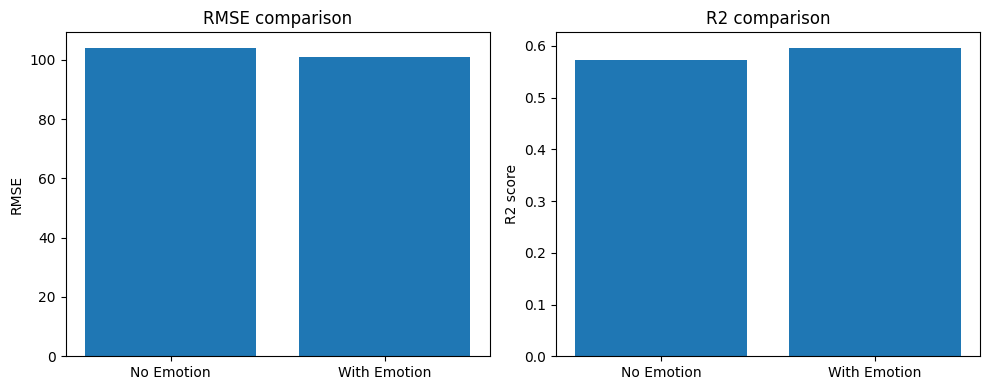

In [ ]:
print("Baseline model without emotions")
print("RMSE:", rmse_no)
print("R2:", r2_no)

print("\nEmotion aware model")
print("RMSE:", rmse_em)
print("R2:", r2_em)

labels = ["No Emotion", "With Emotion"]
rmse_values = [rmse_no, rmse_em]
r2_values = [r2_no, r2_em]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(labels, rmse_values)
plt.title("RMSE comparison")
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
plt.bar(labels, r2_values)
plt.title("R2 comparison")
plt.ylabel("R2 score")

plt.tight_layout()
plt.show()
